In [35]:
!pip install optuna
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 61.6 MB/s eta 0:00:0031m69.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 22.5 MB/s eta 0:00:00


# Comparison with Algorithms from Literature

In [2]:
from typing import List

from math import ceil
import gymnasium
import numpy as np
import torch
import optuna

import stackelberg_mbrl.envs.simple_mdp
from stackelberg_mbrl.envs.querying_env import CountedEnvWrapper
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from sklearn.model_selection import cross_val_score

from stable_baselines3.ppo import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [3]:
class Policy:
    """ Policy that operates on discrete state-/action-spaces """
    def __init__(self, action_probabilities: np.ndarray):
        self.action_probabilities = action_probabilities
    
    def predict(self, observations, **kwargs):
        state = observations.item()

        action_probs = self.action_probabilities[state]
        return torch.multinomial(torch.tensor(action_probs), num_samples=1).numpy(), observations
        

In [42]:
TRAINING_REPS = 10 # how often to train and observe sample efficiency
SAMPLE_EVAL_RATE = 10 # how many samples inbetween two evaluations?
N_EVAL_EPISODES = 10
# MAX_SAMPLES = 2_000 # what is the approximate maximum nr of samples that can be taken
MAX_SAMPLES = 500 # what is the approximate maximum nr of samples that can be taken

In [5]:
def extend_array(arr, new_length):
    if len(arr) < new_length:
        last_element = arr[-1]
        extra_elements = [last_element] * (new_length - len(arr))
        extended_arr = np.concatenate((arr, extra_elements))
    else:
        extended_arr = arr
    return extended_arr

def stack_arrays_with_padding(arrays):
    max_length = max(len(arr) for arr in arrays)
    extended_arrays = [extend_array(arr, max_length) for arr in arrays]
    stacked_array = np.stack(extended_arrays, axis=0)
    return stacked_array

def interpolate(x, y, at):
    return interp1d(x, y, kind="linear", fill_value=(np.min(y), np.max(y)), bounds_error=False)(at)

In [6]:
def plot(all_evals: List, label: str, smooth_factor=2, color="b"):
    intervals = np.arange(0, MAX_SAMPLES, SAMPLE_EVAL_RATE)
    all_evals = np.stack([interpolate(np.array(evals)[:,0],np.array(evals)[:,1],intervals) for evals in all_evals])
    mean_reward = all_evals.mean(axis=0)
    sem_reward = sem(all_evals, axis=0)
    ci_95 = 1.96 * sem_reward

    mean_reward_smooth = gaussian_filter1d(mean_reward, smooth_factor)
    ci_95_smooth = gaussian_filter1d(ci_95, smooth_factor)

    plt.plot(intervals, mean_reward_smooth, label=label, color=color)
    plt.fill_between(intervals, mean_reward_smooth - ci_95_smooth, mean_reward_smooth + ci_95_smooth, color=color, alpha=0.2)

## Dyna-Q

In [7]:
n = 10

In [8]:
class NonDetModel:
    def __init__(self, n_state, n_action, rewards):
        self.Tc: np.ndarray = np.full((n_state, n_action, n_state), 0.0001)
        self.rewards = rewards
        self.encountered_state_action_pairs = set([])
        self.encountered_states = set([])

    def experience(self, s, a, s_next):
        self.Tc[s,a,s_next] += 1
        self.encountered_state_action_pairs.add((s, a))
        self.encountered_states.add(s)
    
    def next_state_distribution(self, s, a):
        return self.Tc[s,a,:] / self.Tc[s,a].sum()
    
    def sample_next_state(self, s, a):
        s_next = torch.multinomial(torch.tensor(self.next_state_distribution(s, a)), num_samples=1).item()
        return s_next, self.rewards[s,a,s_next]

In [9]:
# Adapted from: https://github.com/vojtamolda/reinforcement-learning-an-introduction/blob/main/chapter08/dyna.py
def dyna_q(env, n, max_samples, eps=0.1, eps_mul=1.0, alpha=0.5, gamma=0.95):
    """ Tabular Dyna-Q algorithm per Chapter 8.2 """
    assert type(env.action_space) == gymnasium.spaces.Discrete
    assert type(env.observation_space) == gymnasium.spaces.Discrete
    history = [0]

    # Number of available actions and maximal state ravel index
    n_state, n_action = env.observation_space.n, env.action_space.n

    # Initialization of action value function
    q = np.zeros([n_state, n_action], dtype=float)

    # Initialize policy to equal-probable random
    policy = np.ones([n_state, n_action], dtype=float) / n_action
    assert np.allclose(np.sum(policy, axis=1), 1)

    # Evaluation
    next_eval = 0
    evals = []

    # Model of a deterministic environment
    model = NonDetModel(n_state, n_action, env.rewards)

    while env.samples < max_samples:
        state,_ = env.reset()

        eps *= eps_mul
        done = False
        truncated = False
        while not done and not truncated:
            # Sample action according to the current policy and step the environment forward
            action = np.random.choice(n_action, p=policy[state])
            next, reward, done, truncated, info = env.step(action)
            history += [reward]

            # Update q value with a q-learning update and reset visit counter
            q[state, action] += alpha * (reward + gamma * np.max(q[next]) - q[state, action])
            model.experience(state, action, next)

            # Planning with previously visited state-action pairs
            transitions = list(model.encountered_state_action_pairs)
            for i in range(n):
                p_state, p_action = transitions[np.random.choice(len(transitions))]
                p_next, p_reward = model.sample_next_state(p_state, p_action)
                q[p_state, p_action] += alpha * (p_reward + gamma * np.max(q[p_next]) - q[p_state, p_action])

            # Extract eps-greedy policy from the updated q values
            policy[state, :] = eps / n_action
            policy[state, np.argmax(q[state])] = 1 - eps + eps / n_action
            assert np.allclose(np.sum(policy, axis=1), 1)

            # Prepare the next q update and increase visit counter for all states
            state = next

        if env.samples >= next_eval:
            r_mean,r_std = evaluate_policy(Policy(policy), env.env, n_eval_episodes=N_EVAL_EPISODES)
            evals.append((env.samples, r_mean))
            next_eval = env.samples + SAMPLE_EVAL_RATE
            
    return q, policy, history, evals

def dyna_q_plus(env, n, max_samples, eps=0.1, eps_mul=1.0, alpha=0.5, gamma=0.95, kappa=1e-4, action_only=False):
    """ Tabular Dyna-Q+ algorithm per Chapter 8.3 (action_only=False) or Exercise 8.4 (action_only=True). """
    assert type(env.action_space) == gymnasium.spaces.Discrete
    assert type(env.observation_space) == gymnasium.spaces.Discrete
    history = [0]

    # Number of available actions and maximal state ravel index
    n_state, n_action = env.observation_space.n, env.action_space.n

    # Initialization of action value function and visit counter
    q = np.zeros([n_state, n_action], dtype=float)
    tau = np.zeros([n_state, n_action], dtype=np.int64)

    # Initialize policy to equal-probable random
    policy = np.ones([n_state, n_action], dtype=float) / n_action
    assert np.allclose(np.sum(policy, axis=1), 1)

    # Evaluation
    next_eval = 0
    evals = []

    # Model of a deterministic environment
    model = NonDetModel(n_state, n_action, env.rewards)

    while env.samples < max_samples:
        state,_ = env.reset()

        eps *= eps_mul
        done = False
        truncated = False
        while not done and not truncated:
            # Sample action according to the current policy and step the environment forward
            action = np.random.choice(n_action, p=policy[state])
            next, reward, done, truncated, info = env.step(action)
            history += [reward]

            # Update q value with a q-learning update and reset visit counter
            q[state, action] += alpha * (reward + gamma * np.max(q[next]) - q[state, action])
            model.experience(state, action, next) 
            tau[state, action] = 0

            # Planning that allows taking unvisited actions from visited states
            states = list(model.encountered_states)
            for i in range(n):
                p_state = states[np.random.choice(len(states))]
                p_action = np.random.choice(n_action)
                p_next, p_reward = model.sample_next_state(p_state, p_action)
                bonus = 0 if action_only else kappa * np.sqrt(tau[p_state, p_action])
                q[p_state, p_action] += alpha * (p_reward + bonus + gamma * np.max(q[p_next]) - q[p_state, p_action])

            # Extract eps-greedy policy from the updated q values and exploration bonus
            bonus = kappa * np.sqrt(tau[state]) if action_only else 0
            policy[state, :] = eps / n_action
            policy[state, np.argmax(q[state] + bonus)] = 1 - eps + eps / n_action
            assert np.allclose(np.sum(policy, axis=1), 1)

            # Prepare the next q update and increase visit counter for all states
            state = next
            tau += 1

            if env.samples >= next_eval:
                r_mean,r_std = evaluate_policy(Policy(policy), env.env, n_eval_episodes=N_EVAL_EPISODES)
                evals.append((env.samples, r_mean))
                next_eval = env.samples + SAMPLE_EVAL_RATE

    return q, policy, history, evals

In [10]:
all_evals_dynq = []
for i in range(TRAINING_REPS):
    env = CountedEnvWrapper(gymnasium.make("simple_mdp_2", max_ep_steps=50))
    q, policy, history, evals = dyna_q(env, n, MAX_SAMPLES, eps=0.76, eps_mul=0.69, alpha=0.69, gamma=0.9)
    # print(policy)
    all_evals_dynq.append(evals)

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rewards to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rewards` for environment variables or `env.get_wrapper_attr('rewards')` that will search the reminding wrappers.
  logger.warn(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Co

In [11]:
all_evals_dynq_plus = []
for i in range(TRAINING_REPS):
    env = CountedEnvWrapper(gymnasium.make("simple_mdp_2", max_ep_steps=50))
    # 'eps': 0.1441553715570536, 'eps_mul': 0.10346795021982362, 'alpha': 0.9973707954756627, 'gamma': 0.9347666395713308
    q, policy, history, evals = dyna_q_plus(env, n, MAX_SAMPLES, eps=0.144, eps_mul=0.1, alpha=0.99, gamma=0.93, kappa=0.0001)
    all_evals_dynq_plus.append(evals)

## PPO

In [12]:
# See https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html
class PPOCallback(BaseCallback):
    def __init__(self, eval_env, max_samples):
        super().__init__(verbose=0)
        self.eval_env = eval_env
        self.max_samples = max_samples

        self.next_eval = 0
        self.evals = []

    def _on_training_start(self) -> None:
        pass

    def _on_rollout_start(self) -> None:
        pass

    def _on_step(self) -> bool:
        return self.num_timesteps < self.max_samples

    def _on_rollout_end(self) -> None:
        if self.num_timesteps >= self.next_eval:
            r_mean,r_std = evaluate_policy(self.model.policy, self.eval_env, n_eval_episodes=N_EVAL_EPISODES)
            self.evals.append((self.num_timesteps, r_mean))
            self.next_eval = self.num_timesteps + SAMPLE_EVAL_RATE

    def _on_training_end(self) -> None:
        pass

In [13]:
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=dict(pi=[16, 16], vf=[16, 16]))

In [14]:
all_evals_ppo = []
for i in range(TRAINING_REPS):
    env = gymnasium.make("simple_mdp_2", max_ep_steps=50)
    eval_env = gymnasium.make("simple_mdp_2", max_ep_steps=50)
    
    model_ppo = PPO(
        "MlpPolicy",
        env,
        policy_kwargs=policy_kwargs,
        gamma=1.0,
        n_steps=SAMPLE_EVAL_RATE
    )

    callback = PPOCallback(eval_env, MAX_SAMPLES)
    model_ppo.learn(total_timesteps=MAX_SAMPLES, callback=callback)
    all_evals_ppo.append(callback.evals)

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 10`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 10
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=10 and n_envs=1)
  warnings.warn(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode leng

# Tabular MAL

In [44]:
from stackelberg_mbrl.experiments.experiment_config import EnvConfig, ExperimentConfig, LeaderEnvConfig, LoadPolicy, SampleEfficiency, TableWorldModelConfig
from stackelberg_mbrl.train_mal import train_contextualized_MAL

EXPERIMENT = "delete_this"

all_evals_tab_mal = []
for seed in np.random.rand(TRAINING_REPS):
    data = train_contextualized_MAL(ExperimentConfig(
            experiment_name=EXPERIMENT,
            env_config=EnvConfig(
                env_true_id="simple_mdp_2",
                env_eval_id="simple_mdp_2",
                max_episode_steps=50
            ),
            policy_config=LoadPolicy(
                path="stackelberg_mbrl/experiments/poster_mal_agent_reward/checkpoints/policy_simple_mdp_2.zip",
            ),
            leader_env_config=LeaderEnvConfig(),
            sample_efficiency=SampleEfficiency(
                sample_eval_rate=SAMPLE_EVAL_RATE,
                n_eval_episodes=N_EVAL_EPISODES,
                max_samples=0,
            ),
            world_model_config=TableWorldModelConfig(
                max_training_samples=MAX_SAMPLES,
                init_sample_trajectories=0,
                # noise=0.9256869566965958,
                noise=1.0001,
                batch_size=1,
            ),
            seed=np.floor(10_000*seed).astype(int)
        ), verbose=True)
    all_evals_tab_mal.append(data["evals"])


/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_states` for environment variables or `env.get_wrapper_attr('num_states')` that will search the reminding wrappers.
  logger.warn(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_actions` for environment variables or `env.get_wrapper_attr('num_actions')` that will search the reminding wrappers.
  logger.warn(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rewards to get variables from other wrappers is deprecated and will be removed in v1.0, to get this va

Loading policy model from file.


 72%|███████▏  | 359/500 [00:03<00:01, 92.31it/s] 


Model reward: (36.369999999180436, 1.210619677161202)
Avg Policy Reward on real env:   36.610 ± 0.784
Loading policy model from file.


 50%|████▉     | 248/500 [00:02<00:02, 85.24it/s] 


Model reward: (2.139999996125698, 0.9871170095911576)
Avg Policy Reward on real env:   2.860 ± 1.478
Loading policy model from file.


  7%|▋         | 35/500 [00:02<00:36, 12.81it/s]


Model reward: (36.84999999962747, 0.7375635572703405)
Avg Policy Reward on real env:   36.210 ± 1.015
Loading policy model from file.


  4%|▍         | 22/500 [00:01<00:37, 12.78it/s]


Model reward: (36.28999999910593, 0.9329523040441277)
Avg Policy Reward on real env:   36.690 ± 0.804
Loading policy model from file.


 15%|█▌        | 76/500 [00:03<00:22, 19.10it/s]


Model reward: (36.28999999910593, 0.8616263699439728)
Avg Policy Reward on real env:   36.610 ± 0.480
Loading policy model from file.


 57%|█████▋    | 286/500 [00:04<00:02, 71.43it/s]


Model reward: (36.209999999031425, 0.8039900504384453)
Avg Policy Reward on real env:   36.050 ± 1.200
Loading policy model from file.


 39%|███▉      | 194/500 [00:04<00:06, 48.02it/s]


Model reward: (36.28999999910593, 1.4221111080949385)
Avg Policy Reward on real env:   36.610 ± 0.862
Loading policy model from file.


 29%|██▉       | 145/500 [00:04<00:09, 35.67it/s]


Model reward: (36.28999999910593, 0.9329523040441277)
Avg Policy Reward on real env:   36.610 ± 0.784
Loading policy model from file.


 65%|██████▍   | 323/500 [00:03<00:02, 82.50it/s] 


Model reward: (36.28999999910593, 1.1200000010430813)
Avg Policy Reward on real env:   35.890 ± 1.994
Loading policy model from file.


 31%|███       | 156/500 [00:03<00:08, 41.03it/s]


Model reward: (36.769999999552965, 1.197330364882762)
Avg Policy Reward on real env:   35.970 ± 1.300


## Visualization

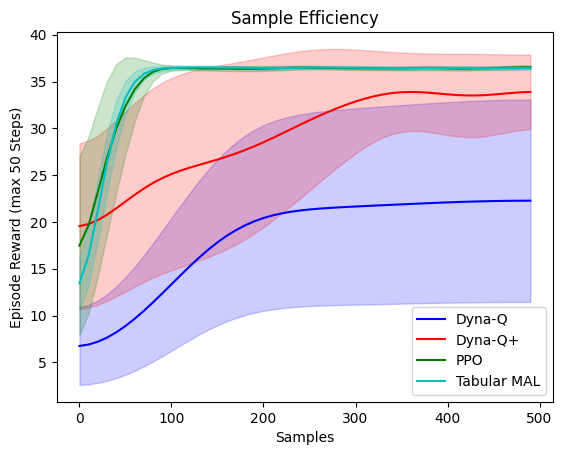

In [43]:
smooth_factor = 5.0
plot(all_evals_dynq, "Dyna-Q", color="b", smooth_factor=smooth_factor)
plot(all_evals_dynq_plus, "Dyna-Q+", color="r", smooth_factor=smooth_factor)
plot(all_evals_ppo, "PPO", color="g")
plot(all_evals_tab_mal, "Tabular MAL", color="c")
plt.title("Sample Efficiency")
plt.ylabel("Episode Reward (max 50 Steps)")
plt.xlabel("Samples")
plt.legend()

# Hyperparameter Tuning

In [ ]:
def objective(trial):
    eps = trial.suggest_float('eps', 1e-6, 1)
    eps_mul = trial.suggest_float('eps_mul', 0.1, 1)
    alpha = trial.suggest_float('alpha', 0.1, 1)
    gamma = trial.suggest_float('gamma', 0.1, 1)
    
    means = []
    for i in range(10):
        env = CountedEnvWrapper(gymnasium.make("simple_mdp_2", max_ep_steps=50))
        q, policy, history, evals = dyna_q(env, n, MAX_SAMPLES, eps=eps, eps_mul=eps_mul, alpha=alpha, gamma=gamma)
        means.append(np.array(evals)[:,1].mean())
    return np.mean(means)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best set of hyperparameters
print('Best hyperparameters: ', study.best_params)
# Print the corresponding performance
print('Best performance: ', study.best_value)

In [69]:
def objective(trial):
    eps = trial.suggest_float('eps', 1e-6, 1)
    eps_mul = trial.suggest_float('eps_mul', 0.1, 1)
    alpha = trial.suggest_float('alpha', 0.1, 1)
    gamma = trial.suggest_float('gamma', 0.1, 1)
    
    means = []
    for i in range(10):
        env = CountedEnvWrapper(gymnasium.make("simple_mdp_2", max_ep_steps=50))
        q, policy, history, evals = dyna_q_plus(env, n, MAX_SAMPLES, eps=eps, eps_mul=eps_mul, alpha=alpha, gamma=gamma)
        means.append(np.array(evals)[:,1].mean())
    return np.mean(means)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best set of hyperparameters
print('Best hyperparameters: ', study.best_params)
# Print the corresponding performance
print('Best performance: ', study.best_value)

[I 2024-06-22 14:09:38,275] A new study created in memory with name: no-name-fe1bdc30-d365-4d83-89db-a667394500a3
/home/yanick/miniforge3/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rewards to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rewards` for environment variables or `env.get_wrapper_attr('rewards')` that will search the reminding wrappers.
  logger.warn(
/home/yanick/miniforge3/envs/stackelberg/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/home/yanick/miniforge3/envs/stackelberg/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. 

KeyboardInterrupt: 